### 2 important points:

It's important to appreciate that we aren't Training the frontier models. We're only providing them with the Test dataset to see how they perform. They don't gain the benefit of the 400,000 training examples that we provided to the Traditional ML models.

HAVING SAID THAT...

It's entirely possible that in their monstrously large training data, they've already been exposed to all the products in the training AND the test set. So there could be test "contamination" here which gives them an unfair advantage. We should keep that in mind.

In [ ]:
# imports

import re
import math
import json
import random
import ollama
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter

In [ ]:
# moved our Tester into a separate package
# call it with Tester.test(function_name, test_dataset)

from items import Item
from testing import Tester

In [ ]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train_lite.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test_lite.pkl', 'rb') as file:
    test = pickle.load(file)

# Before we look at the Frontier

## There is one more model we could consider

In [ ]:
# Write the test set to a CSV

import csv
with open('human_input.csv', 'w', encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    for t in test[:250]:
        writer.writerow([t.test_prompt(), 0])

In [ ]:
# Read it back in

# Of course this doesnt work for my case since ed predicted for his own 
# extra large dataset and mine is the lite version

human_predictions = []
with open('human_output.csv', 'r', encoding="utf-8") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        human_predictions.append(float(row[1]))

In [ ]:
def human_pricer(item):
    idx = test.index(item)
    return human_predictions[idx]

In [ ]:
Tester.test(human_pricer, test)

# Ed now gets into Frontier Models but of course I cant use them so will have to just try with the open-source ones, if I can.

In [ ]:
def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [ ]:
# Try this out

messages_for(test[0])

In [ ]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [ ]:
# The function for ollama

def ollama_call(item):
    response = ollama.chat(
        model="deepseek-v3.1:671b-cloud", 
        messages=messages_for(item),
        options={
            "num_predict": 5 
        }
    )
    reply = response.message.content
    return get_price(reply)

In [ ]:
ollama_call(test[0])

1: Guess: $49.99 Truth: $65.99 Error: $16.00 SLE: 0.07 Item: Setpower Insulated Protective Cover for ...
2: Guess: $9.99 Truth: $9.68 Error: $0.31 SLE: 0.00 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $84.99 Truth: $155.98 Error: $70.99 SLE: 0.36 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $8.99 Truth: $5.59 Error: $3.40 SLE: 0.17 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $35.99 Truth: $98.40 Error: $62.41 SLE: 0.98 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $39.99 Truth: $54.99 Error: $15.00 SLE: 0.10 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $9.99 Truth: $5.71 Error: $4.28 SLE: 0.24 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $5.00 Truth: $9.53 Error: $4.53 SLE: 0.32 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $8.99 Truth: $11.24 Error: $2.25 SLE: 0.04 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $24.99 Truth: $12.88 Error: $12.11 SLE: 0.39 Item: Away NV350 NV351 N

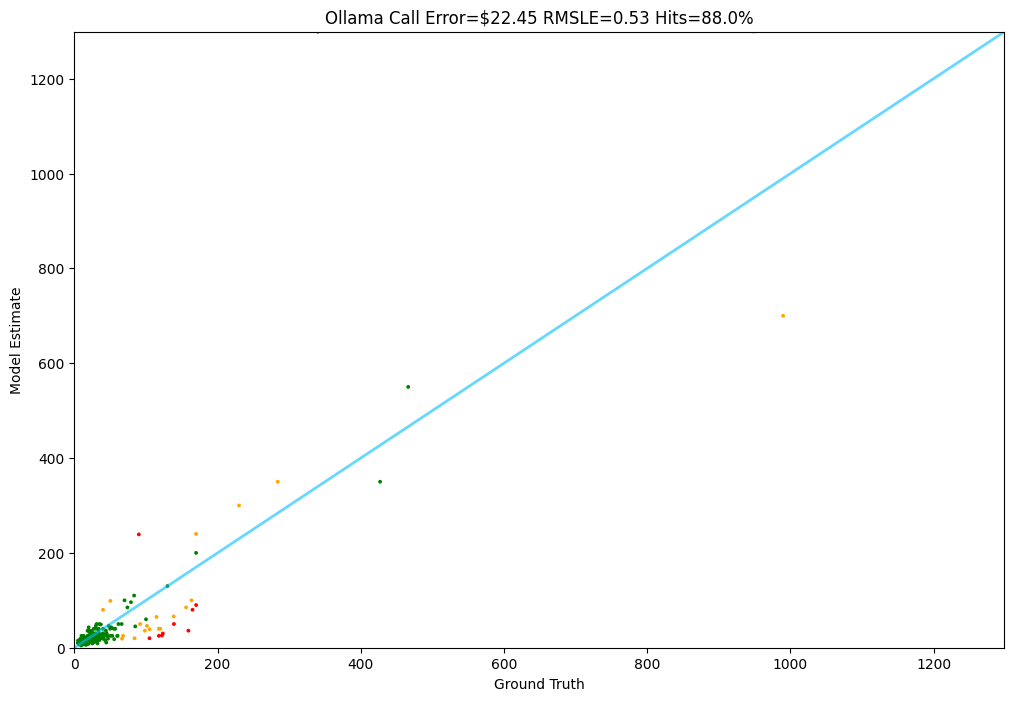

In [30]:
Tester.test(ollama_call, test)